In [3]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.signal import butter, filtfilt
import glob
import pandas as pd
from tqdm import tqdm
import torch as th
from torch.utils.data import Dataset, DataLoader
import os

In [4]:
def process_df(signal_path: str, is_noise = False) -> pd.DataFrame:

    eq_signal_files = glob.glob(f'{signal_path}/**/*.npz', recursive=True)

    path_name = "earthquake"
    if is_noise:
        path_name = "noise"

    data = []
    for eq_path in tqdm(eq_signal_files):
        eq = np.load(eq_path, allow_pickle=True)
        Z = eq[path_name + '_waveform_Z']
        N = eq[path_name +'_waveform_N']
        E = eq[path_name +'_waveform_E']
        data.append({'Z': Z, 'N': N, 'E': E})

    df = pd.DataFrame(data)

    return df

In [5]:
signal_path = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/signal/validation"
df_signal = process_df(signal_path, is_noise = False)
signal_path = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/noise/validation"
df_noise = process_df(signal_path, is_noise = True)

100%|██████████| 6100/6100 [02:56<00:00, 34.56it/s]


In [35]:
def plot_time_domain(df_signal: pd.DataFrame, df_noise: pd.DataFrame, total: int, shuffle = False):

    # Function to compute FFT and plot
    def plot_velocity(signal, title, ax):

        n = len(signal)
        time = range(n)

        # Plot the magnitude of the FFT
        ax.plot(time, signal)
        ax.set_title(title)
        ax.set_xlabel('Time')
        ax.set_ylabel('Velocity')
    
    # Function to compute FFT and plot
    def plot_fft(signal, title, ax):
        # Compute FFT
        fft_values = np.fft.fft(signal)
        fft_magnitude = np.abs(fft_values)  # Magnitude of the FFT

        # Frequency bins (corresponding to FFT output)
        freqs = np.fft.fftfreq(len(signal))

        # Plot the magnitude of the FFT
        ax.plot(freqs, fft_magnitude)
        ax.set_title(title)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('Magnitude')

    # Step 1: Create a figure with subplots
    fig, axs = plt.subplots(2 * total, 3, figsize=(15, 5 * 2 * total))

    if shuffle:
        df_signal = df_signal.sample(frac=1).reset_index(drop=True)
        df_noise = df_noise.sample(frac=1).reset_index(drop=True)

    length = 6000
    start = 2000 
    end = start + length

    # Step 2: Compute and plot FFT for each signal in 'Z', 'N', 'E'
    for i in range(total):
        # Plot for Z signal

        signal = df_signal['Z'].iloc[i][start:end]
        signal = signal / np.max(np.abs(signal))
        noise = df_noise['Z'].iloc[i][0:length]
        noise = noise / np.max(np.abs(noise))

        plot_velocity(signal, f'Time domain of Z signal {i}', axs[2*i, 0])
        plot_velocity(noise, f'Time domain of Z noise {i}', axs[2*i,1])
        plot_velocity(signal + noise, f'Time domain of Z signal + noise {i}', axs[2*i,2])

        plot_fft(signal, f'FFT domain of Z signal {i}', axs[2*i+1, 0])
        plot_fft(noise, f'FFT domain of Z noise {i}', axs[2*i+1, 1])
        plot_fft(signal+noise, f'FFT domain of Z signal + noise {i}', axs[2*i+1, 2])

        y_lim = axs[2*i+1, 0].get_ylim()
        axs[2*i+1,1].set_ylim(y_lim)
        axs[2*i+1,2].set_ylim(y_lim)
        

    # Step 3: Display the plots
    plt.tight_layout()
    plt.show()

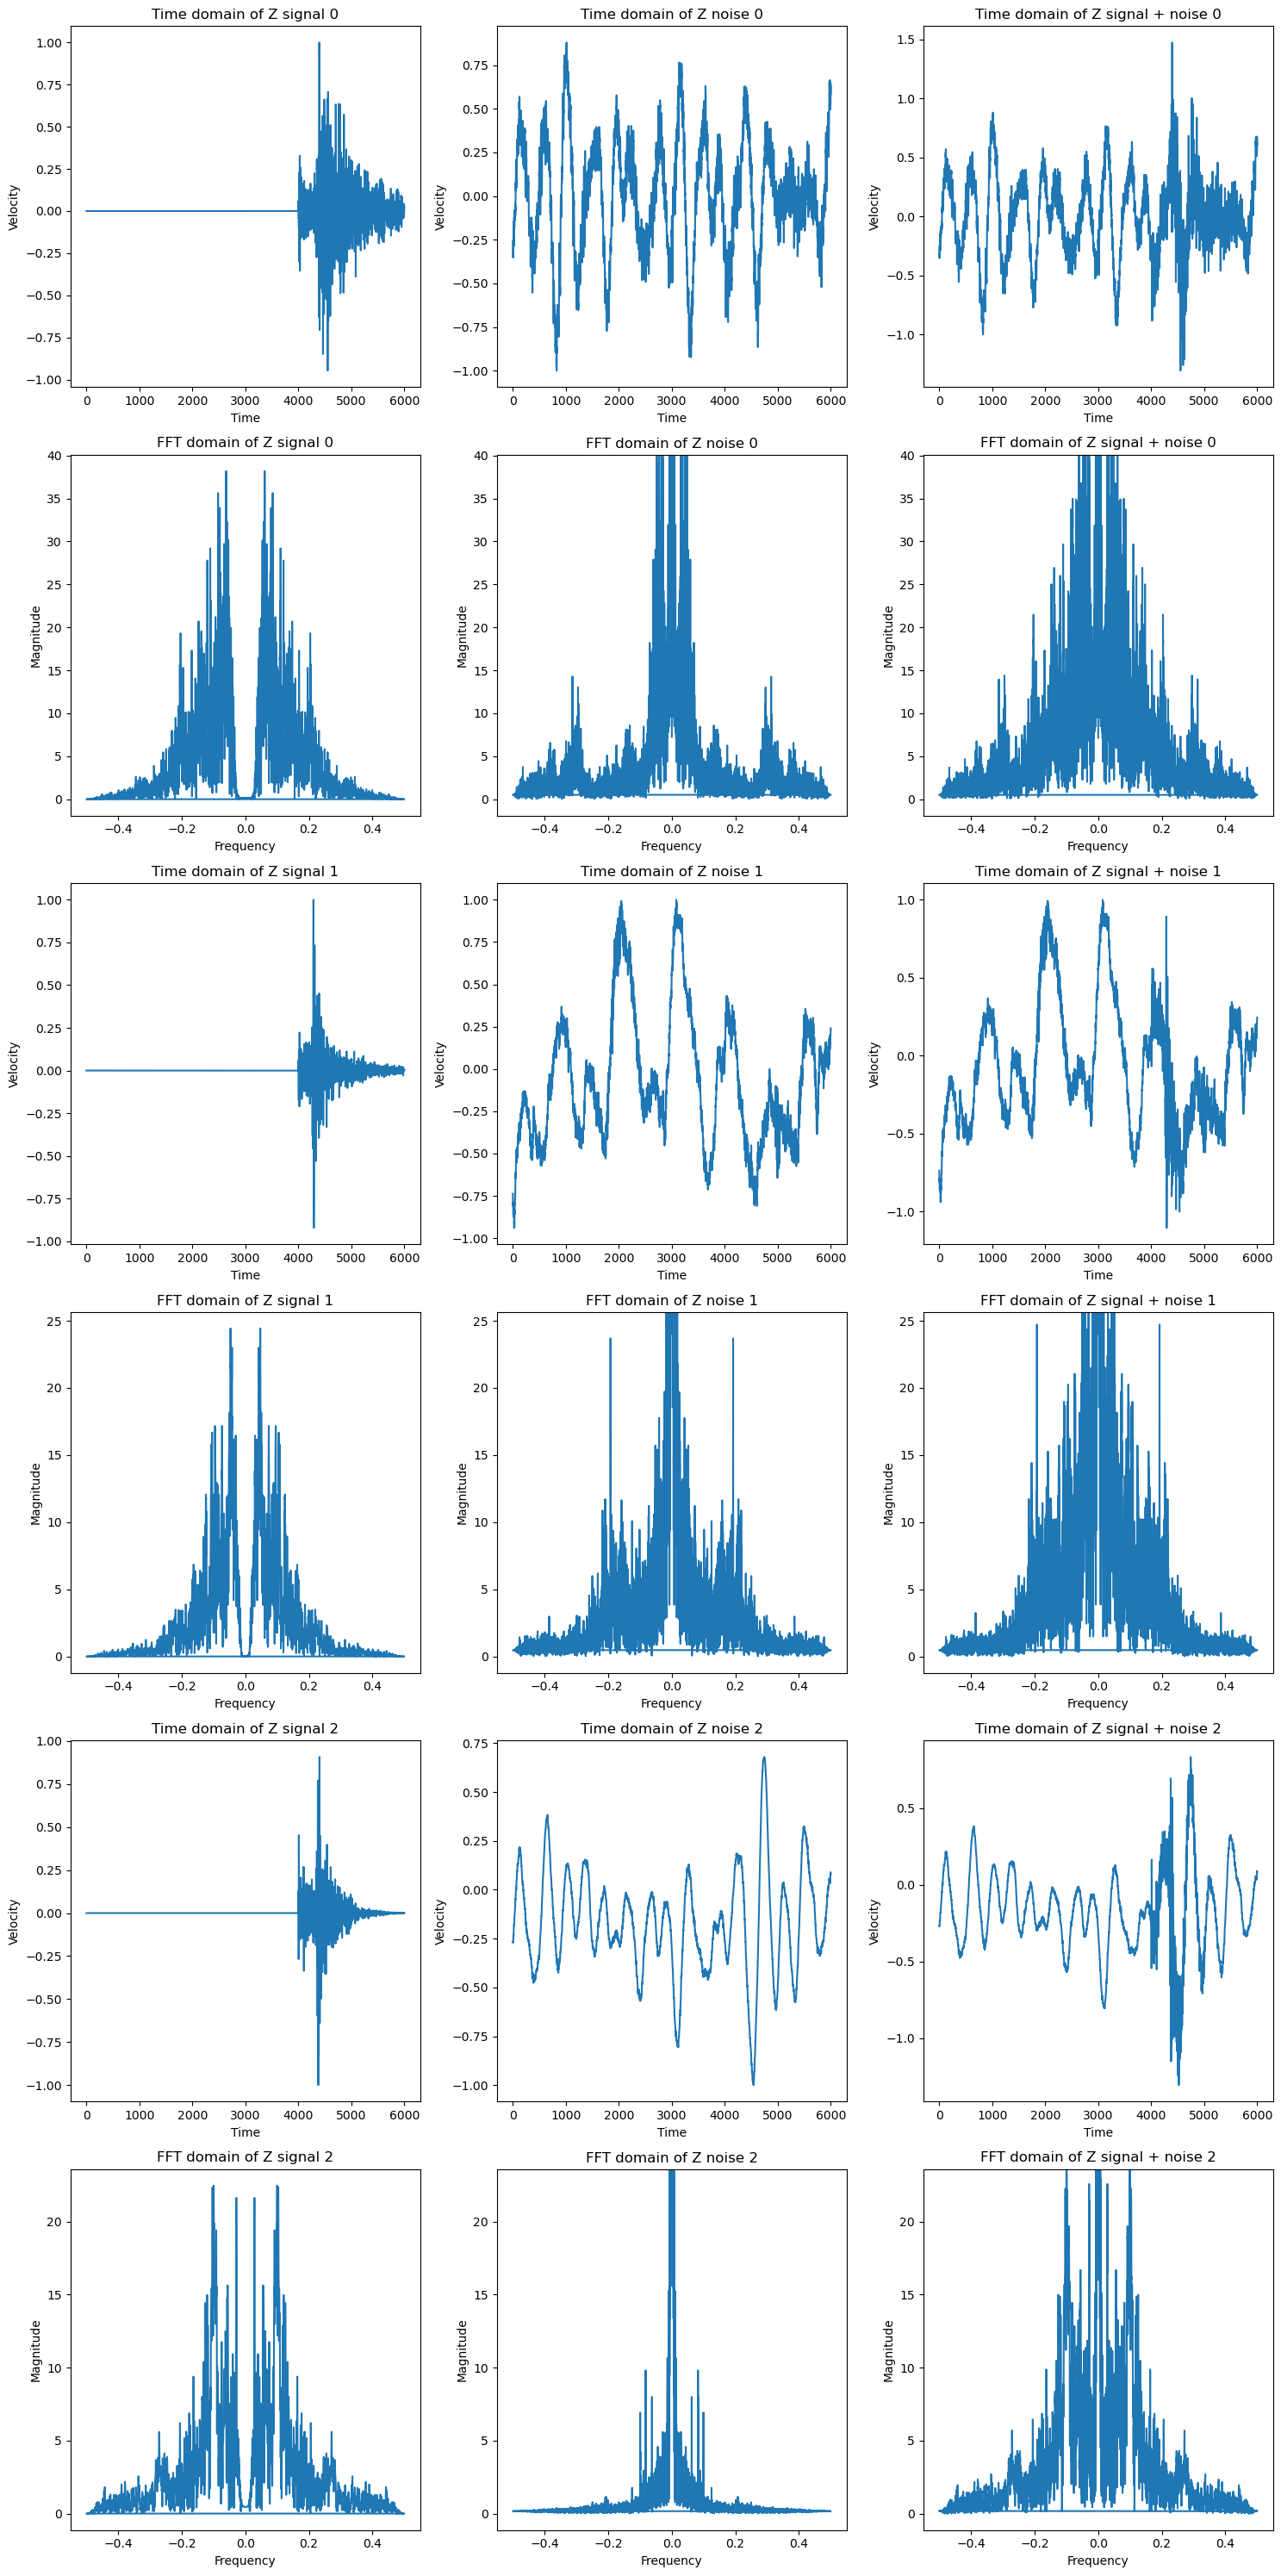

In [36]:
plot_time_domain(df_signal, df_noise, 3, True)

In [ ]:
plot_fourier(df_noise)

In [33]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the filter
def apply_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def objective(lowcut, highcut, order):

    batch_size = 32
    fs = 100

    signal_folder = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/signal/train"
    noise_folder = "C:/Users/cleme/ETH/Master/DataLab/dsl-as24-challenge-3/data/noise/train"
    dataset = SeismicDataset(signal_folder, noise_folder)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    dataset_length = len(dataset)
    print(dataset_length)
    mean = 0

    #print(len(dataloader))

    MAX_BATCHES = 10

    for i, batch in enumerate(dataloader):
        
        if i >= MAX_BATCHES:
            break

        print(i)

        noisy_eq, ground_truth = batch
        noisy_eq_np = noisy_eq.numpy()

        filtered_signals = []
        for i in range(len(noisy_eq)):
            filtered_signal = apply_bandpass_filter(noisy_eq_np[i], lowcut, highcut, fs, order)
            filtered_signals.append(filtered_signal)

        # Convert the filtered signals back to a PyTorch tensor
        filtered_eq = th.tensor(np.array(filtered_signals))

        mean += (1/(MAX_BATCHES * 32)) * th.sum(th.square(ground_truth - filtered_eq))
    
    return mean

In [1]:
import optuna

def objective(trial):
    x = trial.suggest_float('x', -10, 10)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100)


c:\Users\cleme\miniconda3\envs\dsl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-18 14:16:24,881] A new study created in memory with name: no-name-027329bb-7739-4995-8e87-e816b53a3e0c
[I 2024-10-18 14:16:24,889] Trial 0 finished with value: 0.4561299367685324 and parameters: {'x': 2.6753739236663883}. Best is trial 0 with value: 0.4561299367685324.
[I 2024-10-18 14:16:24,894] Trial 1 finished with value: 126.85330208586514 and parameters: {'x': -9.262917121503875}. Best is trial 0 with value: 0.4561299367685324.
[I 2024-10-18 14:16:24,896] Trial 2 finished with value: 100.45440413524292 and parameters: {'x': -8.022694454848104}. Best is trial 0 with value: 0.4561299367685324.
[I 2024-10-18 14:16:24,896] Trial 3 finished with value: 31.462057113561123 and parameters: {'x': -3.609104840664072}. Best is 